# **Detector de Máscara com Deep Learning**
### (Rede Neural Convolucional e Transfer Learning)



#### **Pré - Processamento Dos Dados**

**Montando o Google Drive**

In [0]:
# para acessar o drive do Google
from google.colab import drive
drive.mount('/content/drive')

**Importando as Bibliotecas**

In [0]:
from PIL import Image, ImageOps
import os
from os import listdir, path
from concurrent.futures import ThreadPoolExecutor, as_completed
# contagem de ocorrências de um lista 
from collections import Counter  
import numpy as np
import random as python_random
import time

# para o modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
import tensorflow as tf

# análise do modelo
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

**Carregando uma Imagem**

In [0]:
def converte_imagens_para_array(filename):
    image = Image.open(filename)        # carrega a imagem a partir da localização
    image = image.convert('RGB')        # converte a imagem para RGB
    image = image.resize((160,160))     # redimensiona a imagem
    return np.asarray(image)            # converte a imagem para uma estrutura de dados em array

**Carregando uma Classe**

In [0]:
def carrega_classes(diretorio, classe, imagens, labels):
    print('-' * 10)
    print('processando o diretório:\n{}'.format(diretorio))

    time_start = time.time()  # captura o horário de início para calcular o tempo
    resultado_parcial = []    # armazena os resultados parciais do processamento das imagens

    # inicia as threads para processamento em paralelo
    with ThreadPoolExecutor(max_workers=200) as executor:
        arquivos = listdir(diretorio)
        total = len(arquivos)
        # iterando arquivos
        for i, filename in enumerate(arquivos, start=1):
            print('\rArquivos enviados para thread: {}/{}'.format(i, total), end='')
            filename = path.join(diretorio, filename)

            try:
                # executa a função converte_imagens_para_array em uma thread disponível
                imagem_futura = executor.submit(
                    converte_imagens_para_array,
                    filename
                )

                # imagem_futura é uma "promessa futura" de execução e só retornará o
                # o resultado real quando ela for processada efetivamente
                # então adicionamos essa "promessa" em uma lista para pegar o resultado
                # quando o mesmo existir
                resultado_parcial.append(imagem_futura)
            except Exception as e:
                print("Erro ao ler imagem {} {}".format(path, e))
        print(' ')

        # uma vez que todos os arquivos foram enviados para as threads, já temos
        # todas as "promessas" de resultado, então iteramos em cada uma conforme
        # as threads processam a função converte_imagens_para_array e retornam o
        # resultado para cada arquivo que será adicionado nas respectivas listas
        # esperadas: imagens e labels
        total = len(resultado_parcial)
        for i, imagem_futura in enumerate(as_completed(resultado_parcial), start=1):  # as_completed coloca no começo da lista as imagens finalizadas
            imagem = imagem_futura.result()  # result - aguarda o resultado do processamento
            imagens.append(imagem)  
            labels.append(classe)
            print('\rArquivos processados: {}/{}'.format(i, total), end='')
        print(' ')

    print('Tempo de processamento: {}s\n\n'.format(int(time.time() - time_start)))
    return imagens, labels

**Selecionando Dataset**

In [0]:
def select_data_set(diretorio):
    imagens = []
    labels = []

    for subdir in listdir(diretorio):
        # path
        sub_diretorio = diretorio + subdir + '/'

        if not path.isdir(sub_diretorio):
            print('not dir', sub_diretorio)
            continue
        
        imagens, labels = carrega_classes(sub_diretorio, subdir, imagens, labels)

    return imagens, labels

**Carregando o Dataset Covid-19**

In [9]:
covid_dataset = "/content/drive/My Drive/Colab Notebooks/detector_mascara_Covid19/dataset/faces//"
imagens, labels  = select_data_set(covid_dataset)

# normalizando as imagens
# convertendo de lista para array
imagens = np.array(imagens) / 255.0  
labels = np.array(labels)            

----------
processando o diretório:
/content/drive/My Drive/Colab Notebooks/detector_mascara_Covid19/dataset/faces//1_imagens_nomask/
Arquivos enviados para thread: 1798/1798 
Arquivos processados: 1798/1798 
Tempo de processamento: 73s


----------
processando o diretório:
/content/drive/My Drive/Colab Notebooks/detector_mascara_Covid19/dataset/faces//2_imagens_mask/
Arquivos enviados para thread: 1667/1667 
Arquivos processados: 1667/1667 
Tempo de processamento: 55s




In [10]:
# validar as quantidades de imagens por classe
print(Counter(labels))
print('Total de imagens: {}'.format(len(imagens)))

Counter({'1_imagens_nomask': 1798, '2_imagens_mask': 1667})
Total de imagens: 3465


**Tratando Classes - Labels**

In [0]:
lb = LabelBinarizer() 
labels = lb.fit_transform(labels)  # transforma as labels em [0] e [1]
labels = to_categorical(labels)    # transforma para categórico para usar com keras 

#### **Pré - Treinamento**

**Manter a reprodutibilidade do modelo**

In [0]:
seed_value= 0  # semente usada pelo gerador de números aleatórios
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
python_random.seed(seed_value)
tf.random.set_seed(seed_value)

**Definindo os Hyperparametros**

In [0]:
batch_size = 32              # processa 32 imagens a cada lote
input_shape = (160, 160, 3)  # tamanho da imagem
random_state = seed_value    # semente usada pelo gerador de números aleatórios
alpha = 1e-5                 # taxa de aprendizado
epoch = 30                   # número de época a serem treinadas

**CALLBACKS** 

São classes que auxiliam o treinamento do modelo usando o Keras.


> **ModelCheckpoint**

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# salva o modelo para cada época, e não temos que preocurar com possíveis problemas como travamento da máquina
filepath=('/content/drive/My Drive/Colab Notebooks/model_checkpoint.h5')  # local que será salvo
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

>**ReduceLROnPlateau**

In [0]:
# essa técnica ajudou a melhorar a acurácia do modelo
# auxilia a reduzir a taxa de aprendizado pelo fator (factor) caso não ocorra a mudança no loss
lr_reduce = ReduceLROnPlateau(monitor='val_acc',  # métrica a ser monitorada
                              factor=0.1,         # fator de redução caso esteja em plato
                              min_delta=alpha,    # valor mínimo da perda
                              patience=5,         # espera 05 repetições para alterar o fator
                              verbos=1)           # mostra a barra de progresso

>**Array de Callbacks**

In [0]:
callbacks = [checkpoint, lr_reduce]

**Separando o Dataset em Teste e Treino**

In [0]:
# separa em 20% da base de dados para teste e o restante para treino 
(trainX, testX, trainY, testY) = train_test_split(imagens,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=random_state)

**Data Augmentation**

In [0]:
# novas imagens criadas pelo data augmentation, técnica de "Aumento de Dados" para melhorar o desempenho do modelo
train_datagen = ImageDataGenerator(
        horizontal_flip= True,  # para flipar a imagem
        rotation_range=20,      # graus de rotação
        zoom_range=0.2,         # percentual de zoom na imagem
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
        )

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX,
                              trainY,
                              batch_size=batch_size)  # faz o vínculo das novas imagens com os labels

#### **Modelo com base na VGG 19**
##### Usando a rede convolutiva pré-treinada do Keras modelo VGG19.

*   Usamos os pesos da própria imagenet que consta no VGG19.
*   O tamanho da entrada padrão das imagens para este modelo deverá ter 224 x 224 pixels.
*   Devem ter exatamente 3 canais, sendo que largura e altura não devem ser menores que 32
*   Por exemplo: (200, 200, 3) seria  um valor válido.

**Carregando a VGG 19**

In [0]:
conv_base = VGG19(weights='imagenet',       # qual base de imagem de treino
                  include_top=False,        # false para pegar somente as camadas convolucionais e ignora a parte superior
                  input_shape=input_shape)  # formato de imagem

In [0]:
conv_base.summary()

**Retreinando parte do modelo VGG19 (AJUSTE FINO)**

In [0]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':  # apartir do bloco 5 começa a retreinar
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer_trainable = False


In [0]:
conv_base.summary()

**Criando o modelo com base na VGG19 (Ajuste Fino)**

In [0]:
# executa em sequência
model = models.Sequential()  

# modelo anterior que foi treinado
model.add(conv_base)     

# redução de resolução pela média global
model.add(layers.GlobalAveragePooling2D())  

# aplica normalização durante o treinamento
model.add(layers.BatchNormalization())  

# transforma a imagem em linha
model.add(layers.Flatten())  

# camada densa de 32 neurônios
model.add(layers.Dense(32, activation='relu'))  

# técnica de regularização de abandono, em que os neurônios selecionados aleatoriamente são ignorados durante o treinamento
model.add(layers.Dropout(0.6))  

# camada densa de saída de 02 neurônios usando ativação softmax
model.add(layers.Dense(2, activation='softmax'))  


In [0]:
model.summary()

**Compilando o Modelo**

In [0]:
model.compile(
              loss='binary_crossentropy',  # usa essa perda de entropia cruzada quando houver apenas duas classes de rótulo (0 e 1)
              optimizer= 'adam',           # é um método de descida de gradiente estocástico, baseado na estimativa adaptativa de momentos de primeira e segunda ordem
              metrics=['acc']              # acurácia 
              ) 

**Treinando o Modelo**

In [41]:
# armazena todos os dados gerados pelo modelo
# usa o dataset com o data augmentation
history = model.fit_generator(
                              data_aug,
                              steps_per_epoch=len(trainX)// batch_size,   # divide por 32 e pega a  parte inteira da divisão
                              validation_data=(testX, testY),
                              validation_steps=len(testX) // batch_size,  # divide por 32 e pega a  parte inteira da divisão
                              callbacks=callbacks,
                              epochs=epoch
                              )

Epoch 1/30
86/86 [==============================] - ETA: 0s - loss: 0.5800 - acc: 0.7383
Epoch 00001: val_acc improved from -inf to 0.56566, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoint.h5
86/86 [==============================] - 23s 262ms/step - loss: 0.5800 - acc: 0.7383 - val_loss: 2.1177 - val_acc: 0.5657 - lr: 0.0010
Epoch 2/30
86/86 [==============================] - ETA: 0s - loss: 0.4621 - acc: 0.8077
Epoch 00002: val_acc did not improve from 0.56566
86/86 [==============================] - 20s 234ms/step - loss: 0.4621 - acc: 0.8077 - val_loss: 1.8536 - val_acc: 0.5195 - lr: 0.0010
Epoch 3/30
86/86 [==============================] - ETA: 0s - loss: 0.3985 - acc: 0.8449
Epoch 00003: val_acc improved from 0.56566 to 0.87013, saving model to /content/drive/My Drive/Colab Notebooks/model_checkpoint.h5
86/86 [==============================] - 22s 257ms/step - loss: 0.3985 - acc: 0.8449 - val_loss: 0.4756 - val_acc: 0.8701 - lr: 0.0010
Epoch 4/30
86/86 [=

**Exportando o Modelo**

In [0]:
model.save('./facemask.h5')

#### **Analisando o Modelo**

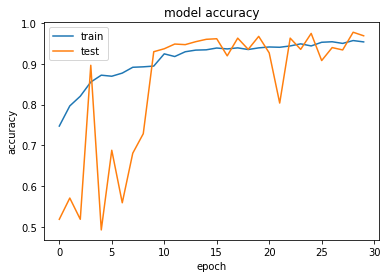

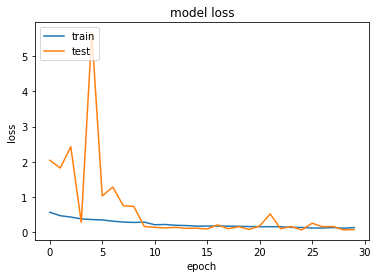

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

> No início, o teste tem picos na acurácia e isso é provavelmente devido ao ReduceLROnPlateau, como podemos observar no gráfico conforme vai passando os plateau a acurácia vai melhorando até ficar bem próxima da acurária do treino.

> O mesmo acontece com o erro no início tem picos e depois vai caindo e ficando mais próximo do loss de treino.


**Matriz Confusão**

In [0]:
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

Acurácia: 0.9683
Sensitividade: 0.9861
Especificidade: 0.9489


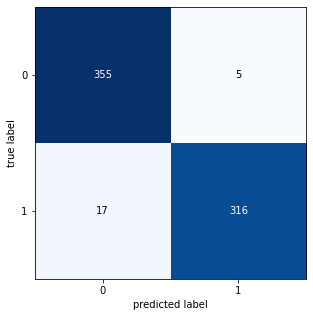

In [0]:
cm = confusion_matrix(y_true, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

#### **Validando o Modelo Criado**
#### Insere uma nova imagem e roda o modelo para verificar se reconhece se a pessoa da foto está com máscara ou não.

In [0]:
# desativa a notação científica para maior clareza
np.set_printoptions(suppress= True)

In [0]:
# carregando o modelo treinado no Teachable Machine
model = tensorflow.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/facemask_30epoca_32neuronios_2.h5')

In [0]:
# cria a matriz array da forma correta para alimentar o modelo keras
# o tamanho ou número de imagens que você pode colocar na matriz é
# determinado pela primeira posição na tupla de forma, neste caso 1 imagem de 224x224x3
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)


In [0]:
# inserindo uma imagem para validar o modelo criado, substitua aqui pelo caminho da sua imagem
image = Image.open('/content/drive/My Drive/Colab Notebooks/SEM.jpg')

In [0]:
# redimensionar a imagem inserida para o tamanho 224 x 224 com a mesma estratégia que no TM2:
# redimensionar a imagem para ter pelo menos 224 x 224 e recortar a partir do centro
size = (224, 224)
image = ImageOps.fit(image, size, Image.ANTIALIAS)

In [0]:
# transforma a imagem de Pillow para em uma matriz numpy
image_array = np.asarray(image)

In [0]:
# normalização da imagem
# faz normalização porque o pixel variam até 255 e já converte em float 32
normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

In [0]:
# carrega a imagem da matriz criada e normaliza
data[0] = normalized_image_array

In [0]:
# verifica a porcentagem prevista para cada classe
pred = model.predict(data)
pred

array([[0.9726155 , 0.02738458]], dtype=float32)

> **O array segue a ordem das classas criadas:**

*   NO-MASK = 0.00000001
*   MASK = 0.9999982

In [0]:
# porcentagem para a Classe: MASK
print(prediction[1])

1.2198711e-06


In [0]:
# roda o modelo para a imagem inserida que foi normalizada
prediction = model.predict(data)[0]  # esse zero é para retirar as porcentagens da matriz array
prediction

array([0.9726155 , 0.02738458], dtype=float32)

In [0]:
# retorna a mensagem se a imagem importada está com máscara ou sem máscara
if prediction [0]>= prediction[1]:
  print('NO MASK')
else: 
  print('MASK')

NO MASK


> O resultado para a imagem inserida foi de "MASK", ou seja, o modelo conseguiu prever que a pessoa na imagem estava com máscara.
